<a href="https://colab.research.google.com/github/chokun7788/PoopforAIB/blob/main/LearnFastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Part1

In [1]:
from fastai.vision.all import *

In [2]:
#ที่อยู่ path ของโฟลเดอร์
base_dir = Path("/content/drive/MyDrive/ForNewDataV2")
train_dir_name = "train"
valid_dir_name = "valid"

In [3]:
#ดู path ว่าอยู่ไหม
print(f"Base directory ของชุดข้อมูล: {base_dir}")
print(f"Train directory: {base_dir/train_dir_name}")
print(f"Valid directory: {base_dir/valid_dir_name}")

Base directory ของชุดข้อมูล: /content/drive/MyDrive/ForNewDataV2
Train directory: /content/drive/MyDrive/ForNewDataV2/train
Valid directory: /content/drive/MyDrive/ForNewDataV2/valid


In [4]:
#เตรียมข้อมูล
TARGET_DIMS_FASTAI = (224,224) #ขนาดข้อมูล (Pixel)
BATCH_SIZE = 32 #จำนวนรูปที่ใช้ประมวลผล
item_tfms_presizing = Resize(460)

In [5]:
#Augmentatuion
batch_tfms_presizing = [*aug_transforms(size=TARGET_DIMS_FASTAI[0],min_scale=0.75),Normalize.from_stats(*imagenet_stats)]

In [6]:
#DataBlock
poop_datablock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                           get_items = get_image_files, #หารูปทั้งหมดที่เป็น (jpg,png)
                           splitter=GrandparentSplitter(train_name=train_dir_name,valid_name=valid_dir_name), #ดึงภาพจาก source(path)
                           get_y=parent_label, #ดึงชื่อโฟลเดอร์แม่ (Parent folder) เป็น Label
                           item_tfms=item_tfms_presizing, #ที่ขนาดเป็น 460ตามข้างบน
                           batch_tfms=batch_tfms_presizing #
                           )

In [7]:
#Create DataLoaders
print("\n สร้าง DataLoader ")
dls = poop_datablock.dataloaders(
    base_dir, #ค้นหาภาพจากไฟล์ที่อยู่
    bs=BATCH_SIZE, #จำนวนรูปภาพที่จะถูกโหลดและประมวลผลพร้อมกันในแต่ละ batch (อันนี้เป็น32)
    num_workers=2 #ทำให้ประมวลผลได้เร็วขึ้น
)


 สร้าง DataLoader 



 แสดงตัวอย่าง batch ของข้อมูล (พร้อมภาพ label)


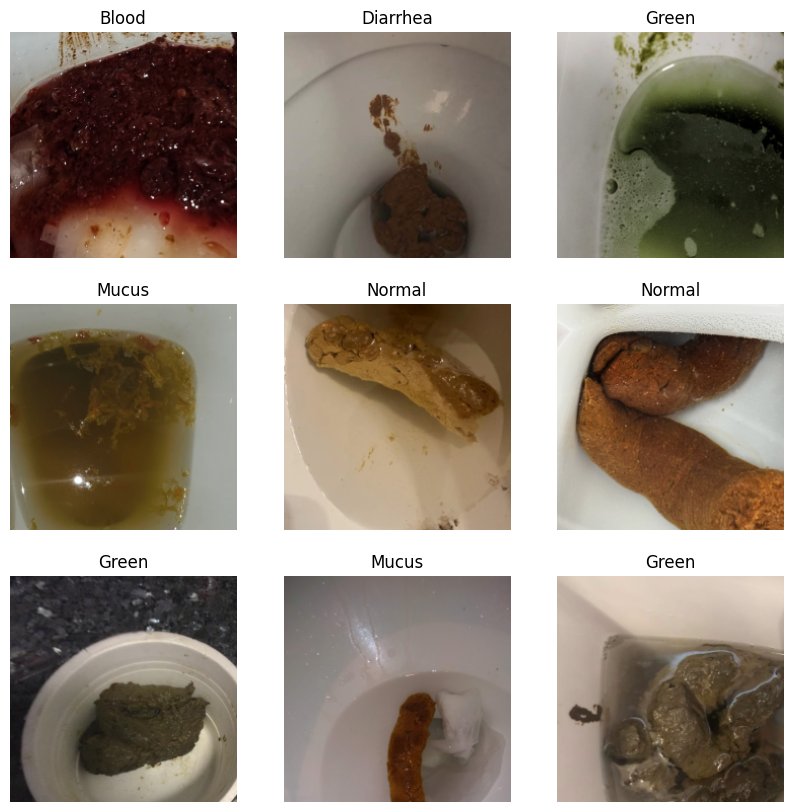

In [11]:
print("\n แสดงตัวอย่าง batch ของข้อมูล (พร้อมภาพ label)")
dls.show_batch(nrows=3,ncols=3,figsize=(10,10)) #สุ่มดึงจาก train แล้วโชว์รูป label ที่ถูกต้องง
plt.show() #โชว์รูป

In [12]:
NUM_CLASSES = dls.c
print(f"จำนวน Class: {NUM_CLASSES}")
print(f"รายชื่อคลาส: {dls.vocab}")

จำนวน Class: 6
รายชื่อคลาส: ['Blood', 'Diarrhea', 'Green', 'Mucus', 'Normal', 'Yellow']


###Path2

In [13]:
#Define Callbacks and Metrics
#Callbacks คือฟังก์ชันที่ถูกเรียกในขั้นตอนต่างๆของ Training Loop
#Metrics คือตัววัดประสิทธิภาพของโมเดล

In [14]:
#Path สำหรับบันทึกโมเดลที่ดีที่สุด
checkpoint_dir_fastai = base_dir/'retailclass_fastai_models' #ชื่อโฟลเดอร์สำหรับ save model
checkpoint_dir_fastai.mkdir(parents=True,exist_ok=True) #สร้างโฟลเดอร์ตามชื่อข้างบน(parnets=True : ถ้า path มีหลายระดับและยังไม่มีโฟลเดอร์ก็จะสร้างให้ , extist_ok=True : ถ้าโฟลเดอร์นั้นมีแล้วก็จะไม่สร้าง)

In [15]:
#callbacks
callbacks_list = [
    SaveModelCallback(monitor='valid_loss',fname='best_model_v2',reset_on_fit=True), #บันทึกโมเดลที่ดีที่สุดตาม valid_loss ,reset_on_fit : จะเริ่มติดตาม best model ใหม่
    EarlyStoppingCallback(monitor='valid_loss',min_delta=0.001,patience=10),
    #Earlystopping เป็นการหยุดฝึกโมเดลอัตโนมัติ ถ้า monirtor(valid_loss) ไม่ดีขึ้น ,
    #min_delta=0.001 : กำหนดค่า valid_loss  จะลดลงอย่างน้อย 0.001 ถึงจะถือว่ามีการปรับปรุง,
    #patience=10 : ถ้า valid_loss ไม่ดีขึ้นตาม min_delta ติดตามกัน 10epochs การฝึกจะหยุดทำให้ช่วยป้องกัน overfit และประหยัดเวลา
    ReduceLROnPlateau(monitor='valid_loss',factor=0.2,patience=5) #Reduce เป็นการลด Learning Rate โดยอัตรโนมัติ ถ้า valid_loss ไม่ดีขึ้นตาม 5 epoch,factor=0.2 : Learning ใหม่จะถูกคูณด้วย 0.2(คือค่าลดลงเหลือ 20% จากค่าเดิม)
]

In [16]:
#ถ้ามี 2 คลาสจะใช้ F1SCORE แต่ถ้ามี 2 คลาสจะใช้ F1SCORE(average='macro')
if NUM_CLASSES == 2:
    f1_metric = F1Score() # average='binary' by default
else:
    f1_metric = F1Score(average='macro') # หรือ 'weighted', 'micro' ตามความเหมาะสม

metrics_list = [f1_metric, accuracy, error_rate] # Metrics ที่จะติดตาม


In [17]:
#สร้าง Learner
print("กำลังสร้าง Learner")
learn = vision_learner(
    dls, #เอาข้อมูลทั้งหมดที่จำเป็นในการฝึกโมเดล (train,valid,vocab(จำนวนคลาส,รายชื่อคลาส))
    resnet50, #CNN ที่มีความลึก50ชั้น คือ resnet50 ผ่านการ pretrain บนชุดข้อมูล ImageNet ให้อัตราโนมัตร โดยการใช้โมเดล pre-train เรียกว่า Transfer Learning
    metrics=metrics_list, #วัดประสิทธิภาพ Learner ให้คำนวณและแสดงผลในระหว่างการและหลังการฝึก
    cbs=callbacks_list, #SaveModelCallback : บันทึกโมเดลที่ดีที่สุด , EarlyStoopingCallback : หยุดการฝึกถ้าโมเดลยังไม่ดี ,ReduceLROnPlateau : ลด learning rate ถ้าโมเดลยังไม่ดี
    path=checkpoint_dir_fastai, #กำหนด path สำหรับ learner
    model_dir = ".", #กำหนด subdirectory ภายใน path สำหรับการบันทึกและโหลด model , "." : หมายความว่าให้บันทึกโมเดลลงใน path โดยไม่สร้างโฟลเดอร์ย่อยที่ชื่อ models อีกครั้ง(ถ้าไม่กำหนด จะถูกทับลงไปอีกที)
    ps=0.5 #ps : dropout probability สำหรับ Fully Connected layers ที่อยู่ใน head ของโมเดลที่เพิ่มเข้ามาต่อจาก resnet50,
    #Droupout เป็นเทคนิคที่ป้องกันไม่ให้เกิด Overfitting โดยการสุ่ม ปิด ตั้งค่า activation เป็น 0 Neurons บางตัวในระหว่างการฝึก , 0.5  : คือ 50% ที่ Neuron แต่ละตัวในชั้น Dropout ถูกปิดในการฝึกแต่ละรอบ
)

กำลังสร้าง Learner


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]


Learning Rate ที่แนะนำจาก lr_find():
  - Minimum (loss ต่ำสุดก่อนตีขึ้น): 0.010000000149011612
  - Steep (จุดที่ชันที่สุดก่อน minimum): 0.0030199517495930195
  - Valley (จุดต่ำสุดในหุบเขาแรก): 0.0010000000474974513
  - Slide (10x ก่อน minimum): 0.0030199517495930195

Learning Rate ที่จะถูกเลือกสำหรับ base_lr (จาก valley): 0.0010000000474974513


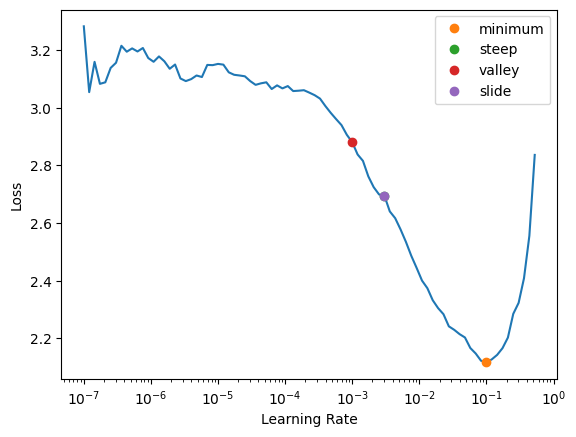

In [57]:
lr_find_suggestions = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print(f"Learning Rate ที่แนะนำจาก lr_find():")
print(f"  - Minimum (loss ต่ำสุดก่อนตีขึ้น): {lr_find_suggestions.minimum}")
print(f"  - Steep (จุดที่ชันที่สุดก่อน minimum): {lr_find_suggestions.steep}")
print(f"  - Valley (จุดต่ำสุดในหุบเขาแรก): {lr_find_suggestions.valley}")
print(f"  - Slide (10x ก่อน minimum): {lr_find_suggestions.slide}")

# เลือก learning rate ที่จะใช้ (อาจจะเริ่มจาก valley หรือ steep)
# หรือดูจากกราฟแล้วเลือกเอง ค่าที่ต่ำกว่า valley เล็กน้อยมักจะปลอดภัย
# เช่น ถ้า valley คือ 1e-3 อาจจะลองใช้ 5e-4 หรือ 1e-3
suggested_lr_for_training = lr_find_suggestions.valley
# หรือถ้ากราฟ valley ไม่ชัดเจน อาจจะใช้ steep
# suggested_lr_for_training = lr_find_suggestions.steep
print(f"\nLearning Rate ที่จะถูกเลือกสำหรับ base_lr (จาก valley): {suggested_lr_for_training}")

In [18]:
#Train Model & Fine-tuning
print("กำลังเริ่ม Train Moddel")
num_fine_tune_epochs = 35 #จำนวน epochs สำหรับการฝึก
initial_freeze_epochs = 3 #จำนวน epochs ให้ส่วน head ของโมเดลที่ถูกสุ่ม weights ขึ้นมาเรียนรู้ที่จะทำงานกับ features ที่สกัดจาก backbone ที่ pre-trained ก่อนโดยไม่รบกวน weights ของ backbone
base_learning_rate = 1e-3 #ใช้สำหรัยฝึกโมเดลที่ควบคุม weights ของโมเดลจะถูกปรับมากน้อยแค่ไหนในแต่ละชั้น , 1e-3 :  หรือ 0.001 เป็นค่าเริ่มต้นที่ใช้กันดีที่สุดแต่อาจแตกต่างกันไปขึ้นอยู่กับข้อมูลและสถาปัตยกรรมโมเดล

กำลังเริ่ม Train Moddel


In [ ]:
learn.fine_tune( #fine_tune คือคำสั่งในการเริ่ม fine_tuning model
    num_fine_tune_epochs, # เทรนจำนวน 10 epochs
    base_lr = base_learning_rate, # learning rate พื้นฐาน
    freeze_epochs = initial_freeze_epochs, #จำนวน epoc ที่ถูกฝึกเฉพาะส่วนของ head
)

epoch,train_loss,valid_loss,f1_score,accuracy,error_rate,time
0,2.641864,1.192880,0.507632,0.547445,0.452555,05:33
1,1.809567,0.843086,0.728801,0.729927,0.270073,00:48
2,1.403283,0.756552,0.790808,0.795620,0.204380,00:48


Better model found at epoch 0 with valid_loss value: 1.1928796768188477.
Better model found at epoch 1 with valid_loss value: 0.8430862426757812.
Better model found at epoch 2 with valid_loss value: 0.7565523982048035.


epoch,train_loss,valid_loss,f1_score,accuracy,error_rate,time
0,0.854526,0.676042,0.779724,0.788321,0.211679,00:47
1,0.798692,0.630377,0.798542,0.802920,0.197080,00:51


Better model found at epoch 0 with valid_loss value: 0.6760423183441162.
Better model found at epoch 1 with valid_loss value: 0.6303771734237671.


In [ ]:
#Plot training
print("แสดงผลการฝึก (Loss และ Metrics)")
learn.recorder.plot_loss()
plt.suptitle("Loss")
plt.show()

learn.recorder.plot_metrics()
plt.suptitle("Metrics")
plt.show()

In [ ]:
#Load best model
print("กำลังโหลดโมเดลที่ดีที่สุด")
learn.load("best_model_v2")
print("โหลดเสร็จละ")

In [ ]:
from fastai.vision.all import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

In [ ]:
validation_results = learn.validate(dl=test_dl)
        metric_names = ['loss'] + [m.name for m in learn.metrics]
        for name, value in zip(metric_names, validation_results):
            value_display = value.item() if isinstance(value, torch.Tensor) else value
            display_name = name.replace('_', ' ').capitalize()
            if name not in ['loss', 'error_rate']:
                print(f"  {display_name}: {value_display * 100:.2f}%")
            else:
                print(f"  {display_name}: {value_display * 100:.2f}%" if name == 'error_rate' else f"  {display_name}: {value_display:.4f}")

In [ ]:
print("\nConfusion Matrix (Test Set):")
        interp.plot_confusion_matrix(figsize=(10,8), cmap="Blues", normalize=False, plot_txt=True)
        plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
        plt.title("Confusion Matrix (Test Set)"); plt.tight_layout(); plt.show()

In [ ]:
# 7.4 แสดง Classification Report
        print("\nClassification Report (Test Set):")
        # ดึง predictions และ true targets จาก interp หรือ learn.get_preds()
        # เพื่อความแม่นยำในการเข้าถึง attribute ที่อาจเปลี่ยนแปลงระหว่างเวอร์ชัน
        # การใช้ learn.get_preds() โดยตรงจะปลอดภัยกว่า
        y_probs, y_true = learn.get_preds(dl=test_dl)
        y_pred = torch.argmax(y_probs, dim=1).numpy()
        y_true_np = y_true.numpy()

        class_names_report = learn.dls.vocab # หรือ test_dl.vocab ถ้ามั่นใจว่าตรงกัน

        unique_labels_in_data = np.unique(np.concatenate((y_true_np, y_pred)))
        num_unique_labels = np.max(unique_labels_in_data) + 1 if len(unique_labels_in_data) > 0 else 0

        if num_unique_labels > 0 and class_names_report and len(class_names_report) > 0:
            labels_for_report = np.arange(num_unique_labels)
            target_names_for_report = list(class_names_report) if len(class_names_report) >= num_unique_labels else None
            if target_names_for_report and len(target_names_for_report) > num_unique_labels:
                 target_names_for_report = target_names_for_report[:num_unique_labels]

            report = classification_report(y_true_np, y_pred,
                                           labels=labels_for_report,
                                           target_names=target_names_for_report,
                                           zero_division=0)
            print(report)